#  <span style='color:red'> **SPAM EMAIL CLASSIFICATION**

This notebook involves training a model for Spam Email Classification. The text data is converted into numerical features using the TF-IDF vectorization and multiple machine learning classification techniques are evaluated on the problem to pick the best model.

***Importing required libraries***

In [1]:
import joblib
import json
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from warnings import filterwarnings

filterwarnings('ignore')

***Loading the data***

In [2]:
data = pd.read_csv('dataset/spam_ham_dataset.csv',usecols=['text','label_num'])
labels = {0:'ham',1:'spam'}

In [3]:
data.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


***Splitting the data into train and test sets***

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['label_num'],train_size=0.8,random_state=7)

***Defining the model and hyperparameter search space***

In [5]:
model_config = {

    'naive_bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [1e-5, 1e-3, 1, 10],
            'force_alpha': [True, False],
            'fit_prior': [True, False],
        }
    },



    'svm': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.5, 1, 3, 5],
        }
    },



    'logistic_regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        }
    }
}

In [6]:
vectorizer = TfidfVectorizer(stop_words='english',max_features=5000)

In [7]:
vectorized_X_train = vectorizer.fit_transform(X_train)

***Using GridSearch to find the best model and hyperparameters***

In [8]:
scores = []

for model_name, model_params in model_config.items():
    gcv = GridSearchCV(model_params['model'],model_params['params'],cv=5,return_train_score=False)
    gcv.fit(vectorized_X_train,y_train)
    scores.append({
        'model_name': model_name,
        'best_params': gcv.best_params_,
        'best_score': gcv.best_score_,
        'best_model': gcv.best_estimator_,
    })

In [9]:
scores_df = pd.DataFrame(scores).sort_values(ascending=False, by='best_score',ignore_index=True)
scores_df

,model_name,best_params,best_score,best_model
0,svm,{'C': 3},0.990087,SVC(C=3)
1,logistic_regression,"{'penalty': 'l2', 'solver': 'saga'}",0.986219,"LogisticRegression(max_iter=1000, solver='saga')"
2,naive_bayes,"{'alpha': 1e-05, 'fit_prior': False, 'force_al...",0.977757,"MultinomialNB(alpha=1e-05, fit_prior=False)"


***Getting the best model***

In [10]:
model = scores_df.loc[0]['best_model']

***Creating a pipeline with the vectorizer and the best model***

In [11]:
pipe = Pipeline([('vectorizer',vectorizer),('best_model', model)])

In [12]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('best_model', SVC(C=3))])

***Evaluating the model's performance***

In [13]:
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       738
           1       0.97      0.98      0.98       297

    accuracy                           0.99      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.99      0.99      0.99      1035



***Plotting the confusion matrix***

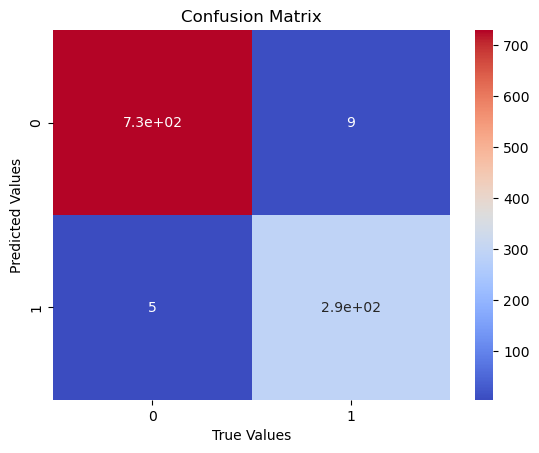

In [14]:
sn.heatmap(cm,annot=True,cmap='coolwarm')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')
plt.show()

***Testing the model***

In [15]:
spam_mail = """Subject: 🎉 Congratulations! You've won a $1,000 gift card!  

Hi there,  

You’ve been selected as our lucky winner! Claim your $1,000 gift card now by clicking the link below:  
👉 [Claim Your Prize Now](http://example.com)  

Hurry! This offer expires in 24 hours.  

Best regards,  
The Rewards Team  
"""

pred = pipe.predict([spam_mail])[0]
labels[pred]

'spam'

In [16]:
ham_mail = """Subject: Meeting Reminder for Tomorrow  

Hi John,  

Just a quick reminder about our meeting scheduled for tomorrow at 2 PM in the conference room. 
Please let me know if there's anything specific you'd like to discuss or if you need to reschedule.  

Looking forward to it!  

Best regards,  
Jane  
"""

pred = pipe.predict([ham_mail])[0]
labels[pred]

'ham'

***Saving the model***

In [17]:
file_path = './model.joblib'

if os.path.exists(file_path):
    os.remove(file_path)

joblib.dump(pipe,file_path)

['./model.joblib']

***Saving the labels***

In [18]:
file_path = './labels.json'

if os.path.exists(file_path):
    os.remove(file_path)

with open(file_path,'w') as f:
    json.dump(labels,f)